<a href="https://colab.research.google.com/github/AceRb6/Procesamiento_de_Lenguaje_Natural/blob/main/PL4_PLN_Cano_Portugal_Israel_Daniel_Arturo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PL4 - PLN
Alumnos:
* Israel Daniel Arturo Cano Portugal
* Manuel Garcia Venegas

# Análisis de Opinión sobre Entidades con Diccionarios y Regresión Ordinal


Este notebook guía paso a paso el análisis de opiniones dirigidas a entidades específicas utilizando herramientas léxicas y modelos de regresión ordinal para las reseñas de trip advisor dataset:

https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews

## 1. Carga de Datos

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("andrewmvd/trip-advisor-hotel-reviews")

print("Path to dataset files:", path)

100%|██████████| 5.14M/5.14M [00:00<00:00, 126MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/trip-advisor-hotel-reviews/versions/2


In [ ]:
import pandas as pd
import os


file_list = os.listdir(path)
csv_file = None
for file_name in file_list:
  if file_name.endswith('.csv'):
    csv_file = os.path.join(path, file_name)
    break
df = pd.read_csv(csv_file)
display(df.head())


,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


## 1.1 Analisis exploratorio

- Generar y graficar la longitud de reseña en palabras
- Generar y graficar numero de textos por rating

Estadísticas Descriptivas de la Longitud de las Reseñas (en palabras):
count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Word_Count, dtype: float64


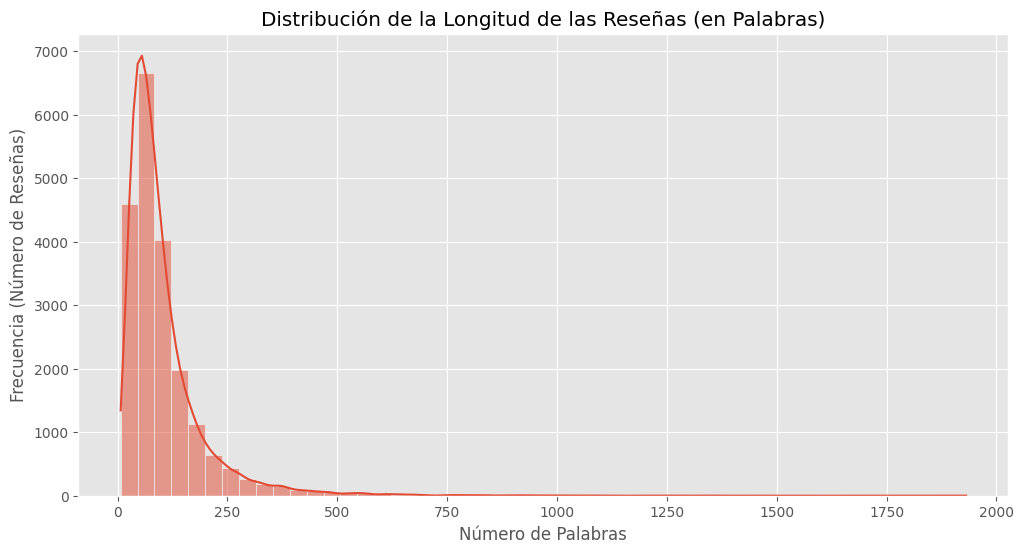

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Creamos una nueva columna 'Word_Count' contando las palabras en cada reseña
df['Word_Count'] = df['Review'].apply(lambda x: len(str(x).split()))

# Mostramos algunas estadísticas descriptivas de la longitud de las reseñas
print("Estadísticas Descriptivas de la Longitud de las Reseñas (en palabras):")
print(df['Word_Count'].describe())

# 1.2 Graficar la longitud de la reseña
plt.style.use('ggplot')
plt.figure(figsize=(12, 6))
sns.histplot(df['Word_Count'], bins=50, kde=True)
plt.title('Distribución de la Longitud de las Reseñas (en Palabras)')
plt.xlabel('Número de Palabras')
plt.ylabel('Frecuencia (Número de Reseñas)')
plt.show()

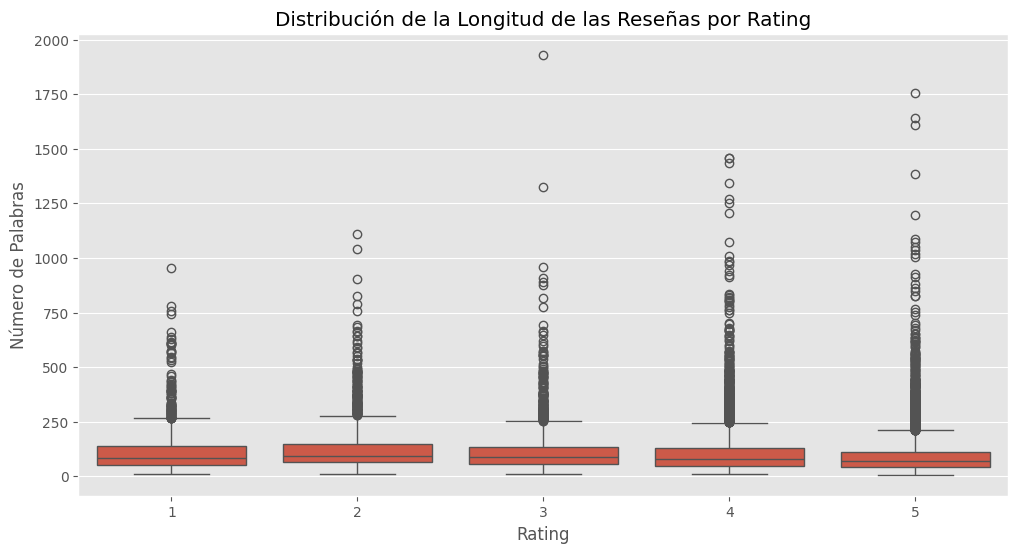

In [ ]:
# Grafica de cajas para ver outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rating', y='Word_Count', data=df)
plt.title('Distribución de la Longitud de las Reseñas por Rating')
plt.xlabel('Rating')
plt.ylabel('Número de Palabras')
plt.show()




Número de Reseñas por Calificación:
Rating
1    1421
2    1793
3    2184
4    6039
5    9054
Name: count, dtype: int64


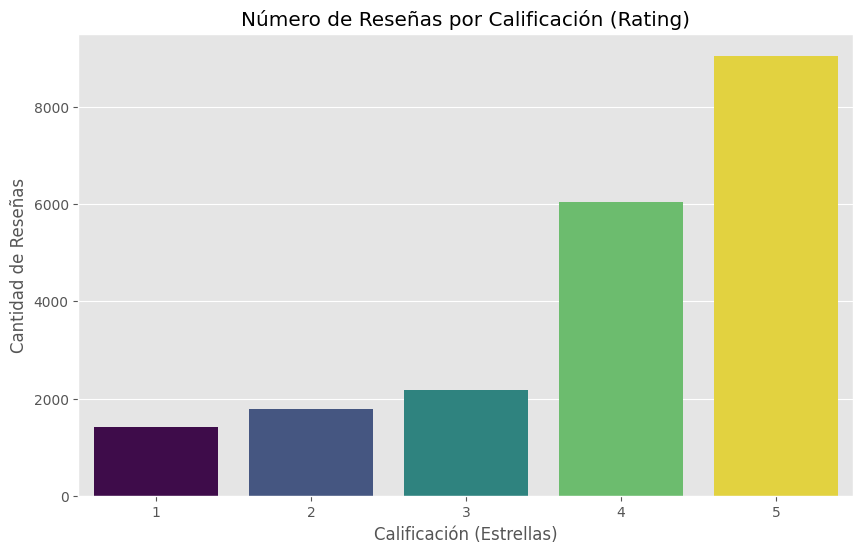

In [ ]:
# 2.1 Generar el número de textos por rating
rating_counts = df['Rating'].value_counts().sort_index()

print("\nNúmero de Reseñas por Calificación:")
print(rating_counts)

# 2.2 Graficar el número de textos por rating
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df, palette='viridis', hue='Rating', legend=False)
plt.title('Número de Reseñas por Calificación (Rating)')
plt.xlabel('Calificación (Estrellas)')
plt.ylabel('Cantidad de Reseñas')
plt.show()

## Balance por submuestreo



identificamos cuál es la clase con menos muestras (la calificación de '1' con 1,421 reseñas). Luego, tomaremos una muestra aleatoria de ese mismo tamaño de todas las demás clases.

El tamaño de la clase más pequeña (Rating 1) es: 1421 reseñas.

Distribución de clases en el nuevo DataFrame balanceado:
Rating
1    1421
2    1421
3    1421
4    1421
5    1421
Name: count, dtype: int64


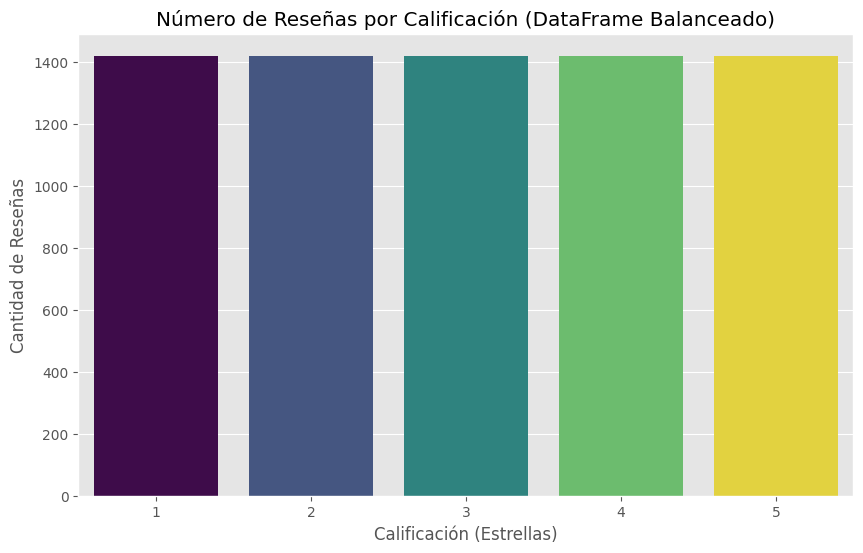

In [ ]:

# Encontrar el tamaño de la clase más pequeña
min_class_size = df['Rating'].value_counts().min()
print(f"El tamaño de la clase más pequeña (Rating 1) es: {min_class_size} reseñas.\n")

# Crear un nuevo DataFrame balanceado
df_balanceado = df.groupby('Rating').sample(n=min_class_size, random_state=42)

# Verificar el nuevo balance
print("Distribución de clases en el nuevo DataFrame balanceado:")
print(df_balanceado['Rating'].value_counts())

# Graficar la nueva distribución para confirmar
plt.figure(figsize=(10, 6))
sns.countplot(x='Rating', data=df_balanceado, palette='viridis', hue='Rating', legend=False)
plt.title('Número de Reseñas por Calificación (DataFrame Balanceado)')
plt.xlabel('Calificación (Estrellas)')
plt.ylabel('Cantidad de Reseñas')
plt.show()

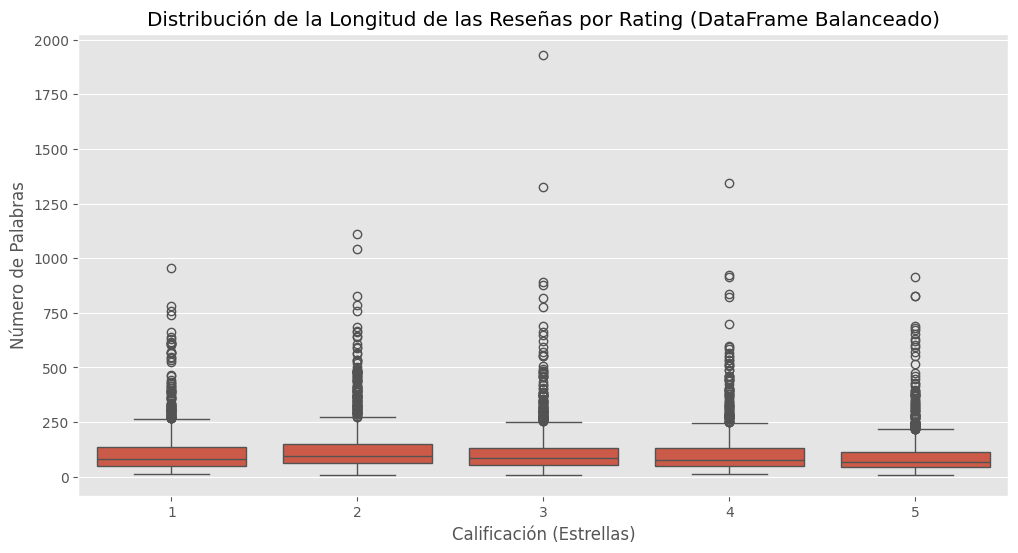

In [ ]:
# Grafica de cajas
plt.figure(figsize=(12, 6))
sns.boxplot(x='Rating', y='Word_Count', data=df_balanceado)
plt.title('Distribución de la Longitud de las Reseñas por Rating (DataFrame Balanceado)')
plt.xlabel('Calificación (Estrellas)')
plt.ylabel('Número de Palabras')
plt.show()

Límite inferior (cuantil 1%): 16 palabras
Límite superior (cuantil 99%): 214 palabras

Tamaño del DataFrame original: 20491
Tamaño del DataFrame balanceado: 7105
Tamaño del DataFrame final (balanceado y sin outliers): 6312


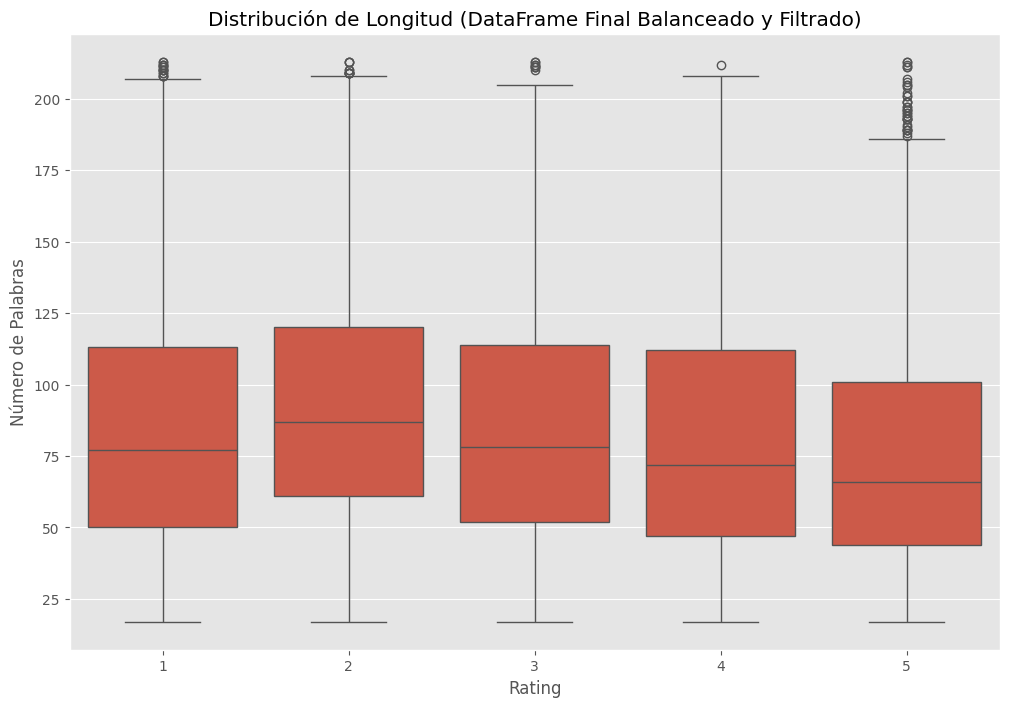

In [ ]:
# Calcular los límites de los cuantiles de %1 a %90
limite_inferior = df_balanceado['Word_Count'].quantile(0.01)
limite_superior = df_balanceado['Word_Count'].quantile(0.90)

print(f"Límite inferior (cuantil 1%): {limite_inferior:.0f} palabras")
print(f"Límite superior (cuantil 99%): {limite_superior:.0f} palabras\n")

# Filtrar el DataFrame para quedarnos con las reseñas dentro de esos límites
df_final = df_balanceado[
    (df_balanceado['Word_Count'] > limite_inferior) &
    (df_balanceado['Word_Count'] < limite_superior)
]

print(f"Tamaño del DataFrame original: {len(df)}")
print(f"Tamaño del DataFrame balanceado: {len(df_balanceado)}")
print(f"Tamaño del DataFrame final (balanceado y sin outliers): {len(df_final)}")

# Visualizar el nuevo gráfico de cajas para confirmar la reducción de outliers
plt.figure(figsize=(12, 8))
sns.boxplot(x='Rating', y='Word_Count', data=df_final)
plt.title('Distribución de Longitud (DataFrame Final Balanceado y Filtrado)')
plt.xlabel('Rating')
plt.ylabel('Número de Palabras')
plt.show()

Ya filtrado entre cuartiles entonces podemos usar tras esta seleccion de datos.

## 2. Preprocesamiento de Texto

In [ ]:
# reiniciar indexado
df = df_final.reset_index(drop=True)

In [ ]:
#Imprimir primer documento
display(df['Review'][5595])

'outstanding experience wonderful experience beautiful paris hotel, despite fact travelling children hotel staff welcomed did make stay enjoyable, concierge staff knowledgeable helpful, meal ultra expensive hotel restaurant wait staff superb, paper colored pencils ready custom puzzles le meurice children decipher waited food, offered children restroom remain table enjoy dinners, called desk ask converter materialized room minutes, room service prompt hotel staff friendly, overall outstanding experience worth cost,  '

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 7.2 MB/s eta 0:00:00


In [ ]:
import re
import spacy
import nltk
import contractions
from nltk.corpus import stopwords
nltk.download('stopwords')

# Cargar modelo de spaCy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Obtener y personalizar stopwords
stop_words = set(stopwords.words("english"))
negation_words = {"no", "not", "nor", "ain", "aren", "couldn", "didn", "doesn", "hadn", "hasn", "haven", "isn", "mightn", "mustn", "needn", "shouldn", "wasn", "weren", "won", "wouldn"}
stop_words = stop_words - negation_words


def clean_text(text):
    text = contractions.fix(text)
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 4. Lematización con spaCy
    doc = nlp(text)
    # 5. Eliminar stopwords y tokens cortos (tokens de 1 letra como 's' después de '50s')
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and len(token.text) > 1]

    return tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Se decidió implementar la tokenización después de ver como tenian varias caracteristicas textuales, donde en una misma opinión coexisten entidades específicas (como staff o room), descriptores de sentimiento (rude, perfect) y datos concretos (precios como $25). Para que un algoritmo pudiera interpretar estos componentes dispares, era indispensable segmentar el texto en unidades discretas o "tokens". Este aislamiento fue el único modo de proceder con los análisis anterior, como evaluar la polaridad de cada palabra con VADER, agrupar términos semánticos mediante lematización (rooms a room), y finalmente, transformar estas complejas opiniones cualitativas en el formato numérico y estructurado que el modelo de regresión ordinal exige para su entrenamiento.

In [ ]:
#Limpieza y tokenizado
df['review_clean'] = df['Review'].apply(clean_text)
df.head()

,Review,Rating,Word_Count,review_clean
0,"old rude blah reason stayed jacuzzi suite, wis...",1,49,"[old, rude, blah, reason, stay, jacuzzi, suite..."
1,"hated, just got punta cana stayed melia caribe...",1,60,"[hate, get, punta, cana, stay, melia, caribe, ..."
2,absolutely horrible stayed 30th august jolly c...,1,91,"[absolutely, horrible, stay, 30th, august, jol..."
3,"problems way stayed 2 nights, property not bad...",1,37,"[problem, way, stay, night, property, not, bad..."
4,tourists stay away bad address unless want roc...,1,76,"[tourist, stay, away, bad, address, unless, wa..."


In [ ]:
#ahora la reseña limpia nada mas no quiero tokenizar
df['review_clean'] = df['review_clean'].apply(lambda x: ' '.join(x))
df.head()

,Review,Rating,Word_Count,review_clean
0,"old rude blah reason stayed jacuzzi suite, wis...",1,49,old rude blah reason stay jacuzzi suite wish s...
1,"hated, just got punta cana stayed melia caribe...",1,60,hate get punta cana stay melia caribe tropical...
2,absolutely horrible stayed 30th august jolly c...,1,91,absolutely horrible stay 30th august jolly car...
3,"problems way stayed 2 nights, property not bad...",1,37,problem way stay night property not bad stay r...
4,tourists stay away bad address unless want roc...,1,76,tourist stay away bad address unless want rock...


## 3. Análisis de Sentimiento con Diccionario (VADER)

pip install vaderSentiment

In [ ]:
!pip install vaderSentiment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.9 MB/s eta 0:00:00


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    return sia.polarity_scores(text)['compound']

df['vader_score'] = df['review_clean'].apply(get_sentiment)
df.head()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


,Review,Rating,Word_Count,review_clean,vader_score
0,"old rude blah reason stayed jacuzzi suite, wis...",1,49,old rude blah reason stay jacuzzi suite wish s...,0.6369
1,"hated, just got punta cana stayed melia caribe...",1,60,hate get punta cana stay melia caribe tropical...,-0.7495
2,absolutely horrible stayed 30th august jolly c...,1,91,absolutely horrible stay 30th august jolly car...,0.4205
3,"problems way stayed 2 nights, property not bad...",1,37,problem way stay night property not bad stay r...,-0.7685
4,tourists stay away bad address unless want roc...,1,76,tourist stay away bad address unless want rock...,-0.8342


## 4. Extracción de Características

- Mostrar palabras con fuerte polaridad (palabras positivas y negativas) por reseña

    - Usar VADER palabra por palabra (compound > 0.3 o < -0.3).
    - Separar positivas, negativas.

- Construir una nube de palabras relevantes emocionalmente.

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
nltk.download('punkt_tab')

# Función para extraer palabras con polaridad fuerte de un texto
def extract_polarized_words(text):
    positive_words = []
    negative_words = []
    # Usamos nltk.word_tokenize para separar mejor las palabras y puntuación
    tokens = nltk.word_tokenize(text)

    for word in tokens:
        score = sia.polarity_scores(word)['compound']
        if score > 0.3:
            positive_words.append(word.lower())
        elif score < -0.3:
            negative_words.append(word.lower())

    return {'positive_words': positive_words, 'negative_words': negative_words}

# Aplicamos la función a la columna de reseñas ORIGINALES ('Review')
polarity_cols = df['Review'].apply(extract_polarized_words).apply(pd.Series)

# Unimos estas nuevas columnas a nuestro DataFrame principal
df = pd.concat([df, polarity_cols], axis=1)

# Mostramos las nuevas columnas para algunas reseñas
print("Reseñas con sus palabras polarizadas extraídas:")
display(df[['Review', 'positive_words', 'negative_words', 'Rating']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Reseñas con sus palabras polarizadas extraídas:


,Review,positive_words,negative_words,Rating
0,"old rude blah reason stayed jacuzzi suite, wis...","[wish, charm, fan, great, good]","[rude, rude]",1
1,"hated, just got punta cana stayed melia caribe...","[true, good, hope, like, recommend]","[hated, negative, hate, poor, horrible, doubt]",1
2,absolutely horrible stayed 30th august jolly c...,"[jolly, best, special, helpful, better, diamon...","[horrible, terrible, rude, unfriendly, worst, ...",1
3,"problems way stayed 2 nights, property not bad...",[pleasant],"[problems, bad, denied, annoying]",1
4,tourists stay away bad address unless want roc...,[holiday],"[bad, bad]",1


In [ ]:
# Agrupar por 'Rating' y seleccionar 5 reseñas de cada grupo
reviews_by_rating = df.groupby('Rating').head(5)

# Iterar sobre las reseñas seleccionadas e imprimirlas
print("Mostrando 5 reseñas para cada Rating con sus palabras polarizadas:")
for index, row in reviews_by_rating.iterrows():
    print("-" * 50)
    print(f"Rating: {row['Rating']}")
    print(f"Review:\n{row['Review']}")
    print(f"Palabras Positivas: {', '.join(row['positive_words']) if row['positive_words'] else 'Ninguna'}")
    print(f"Palabras Negativas: {', '.join(row['negative_words']) if row['negative_words'] else 'Ninguna'}")



Mostrando 5 reseñas para cada Rating con sus palabras polarizadas:
--------------------------------------------------
Rating: 1
Review:
old rude blah reason stayed jacuzzi suite, wish stayed, hotel charm lobby, rooms old 50, no fan bathroom tiles falling missing screws tub, smoke seeped floor came bathroom, receptionists rude did n't tell room, oh 25 park car just great, good thing close cheesecake factory, stay, especially price- spendy,  
Palabras Positivas: wish, charm, fan, great, good
Palabras Negativas: rude, rude
--------------------------------------------------
Rating: 1
Review:
hated, just got punta cana stayed melia caribe tropical.i want say did site read reviews hotel did negative feedback decided say absolutely true hate talk dominican people dominican descent im surprised 4-5 star hotel poor quality service completely food absolutely horrible, good thing restaurants make reservations 24 hours advance ridicolous, visit country hope hotels strip not like doubt melia recomm

El análisis de polaridad con VADER valida exitosamente el enfoque, demostrando una fuerte correlación entre las palabras usadas y la calificación final. Se revelan claramente los temas o "entidades" más importantes para los clientes como el personal (rude, friendly), la limpieza (dirty, clean) y el costo (expensive, value) a través de las palabras con mayor carga emocional. Más importante aún, se observa un claro "gradiente de sentimiento": las reseñas de 1 estrella usan palabras catastróficas (horrible, worst), las de 3 estrellas usan términos funcionales (nice, good), y las de 5 estrellas emplean un lenguaje eufórico (paradise, perfect). Esta progresión de intensidad es una característica ideal para alimentar un modelo de regresión ordinal.

Sin embargo, el análisis también expone las limitaciones de VADER, principalmente su incapacidad para detectar el contexto y el sarcasmo, como cuando califica "great" de forma positiva dentro de una queja evidente. A pesar de estos detalles, la principal conclusión es que este método permite una ingeniería de características muy potente. Al contar las palabras positivas y negativas o al identificar la presencia de términos de sentimiento extremo, se pueden crear variables predictivas robustas que, combinadas con otras técnicas como TF-IDF, mejorarán significativamente la precisión y la interpretabilidad del modelo de análisis de opinión.

In [ ]:
# Preparar los datos: Juntar todas las palabras en un solo texto para cada categoría
positive_text = ' '.join([word for sublist in df['positive_words'] for word in sublist])
negative_text = ' '.join([word for sublist in df['negative_words'] for word in sublist])

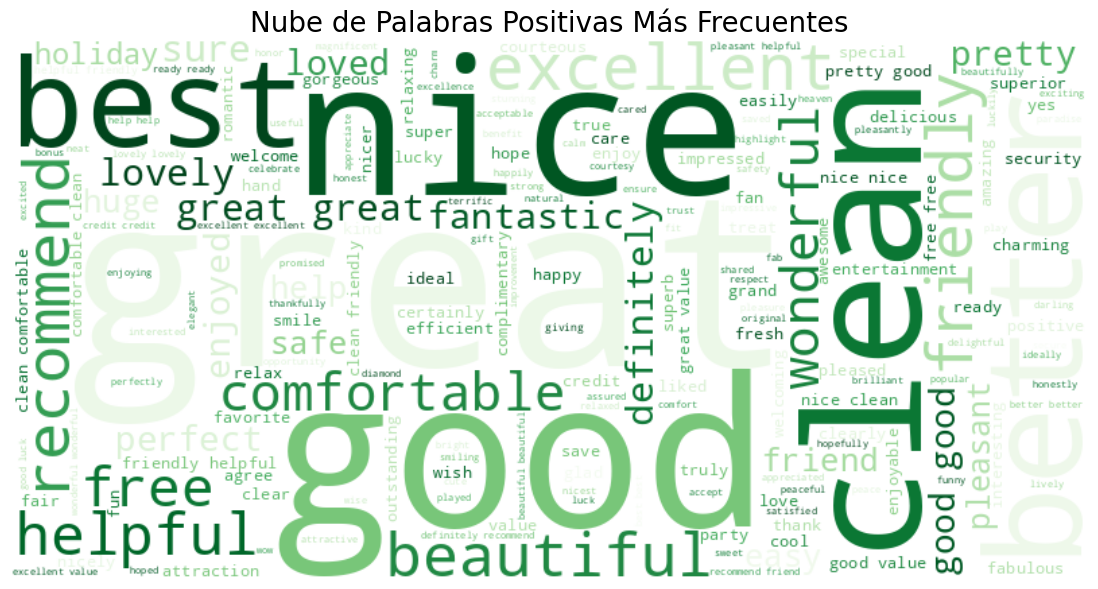

In [ ]:
# 2. Crear y visualizar la nube de palabras POSITIVAS
plt.style.use('default') # Usamos el estilo por defecto para que no interfiera ggplot
wordcloud_positive = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras Positivas Más Frecuentes', fontsize=20)
plt.show()

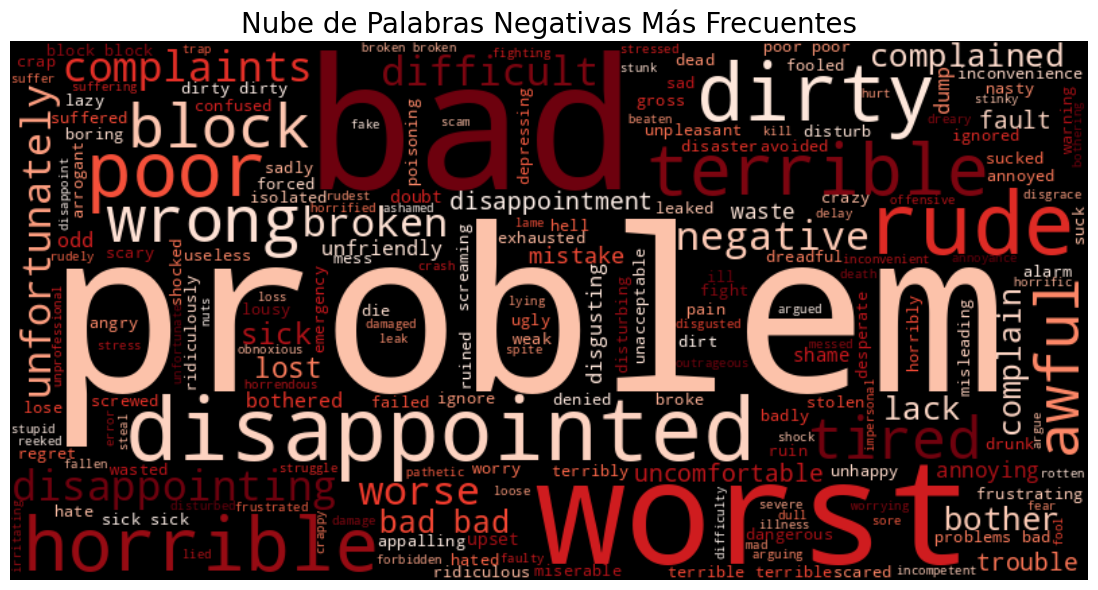

In [ ]:
# Crear y visualizar la nube de palabras NEGATIVAS
wordcloud_negative = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras Negativas Más Frecuentes', fontsize=20)
plt.show()

## 5. Vectorizacion


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    lowercase=False,          # Ya está todo en minúsculas
    stop_words=None,          # Ya se eliminaron stopwords
    max_features=3000,        # Vocabulario limitado para evitar alta dimensionalidad (ajustable)
    ngram_range=(1, 2),       # Unigramas + Bigramas: capturan contexto sin ser demasiado costosos
    max_df=0.9,               # Filtra términos presentes en más del 90% de los textos (poco informativos)
    min_df=10                 # Mantiene términos que aparecen en al menos 10 documentos
)

X_tfidf = vectorizer.fit_transform(df['review_clean'])


**Justificación de los parámetros**



| Parámetro      | Valor  | Justificación                                                           |
| -------------- | ------ | ----------------------------------------------------------------------- |
| `max_features` | 3000   | Limita el vocabulario a las 3000 palabras más informativas              |
| `ngram_range`  | (1, 2) | Unigramas y bigramas permiten capturar contexto sin generar mucho ruido |
| `max_df`       | 0.9    | Elimina términos extremadamente comunes que no discriminan entre clases |
| `min_df`       | 10     | Evita incluir términos muy raros que no aportan generalización          |


Para inspeccionar las primeras palabras del vocabulario aprendido

In [ ]:
features = vectorizer.get_feature_names_out()
print(features[:20])


['10' '10 day' '10 min' '10 minute' '10 pm' '10 year' '100' '1000' '1015'
 '11' '11 pm' '12' '12 hour' '13' '14' '15' '15 min' '15 minute' '150'
 '16']


## 6. Agrupamiento no supervisado (K-Means sobre palabras relevantes)

¿qué tipo de palabras están en cada clúster?
¿Son intensificadores? ¿Adjetivos? ¿Modismos?

Como no tenemos etiquetas, usaremos el método del codo y el Silhouette Score para determinar un buen valor de k.



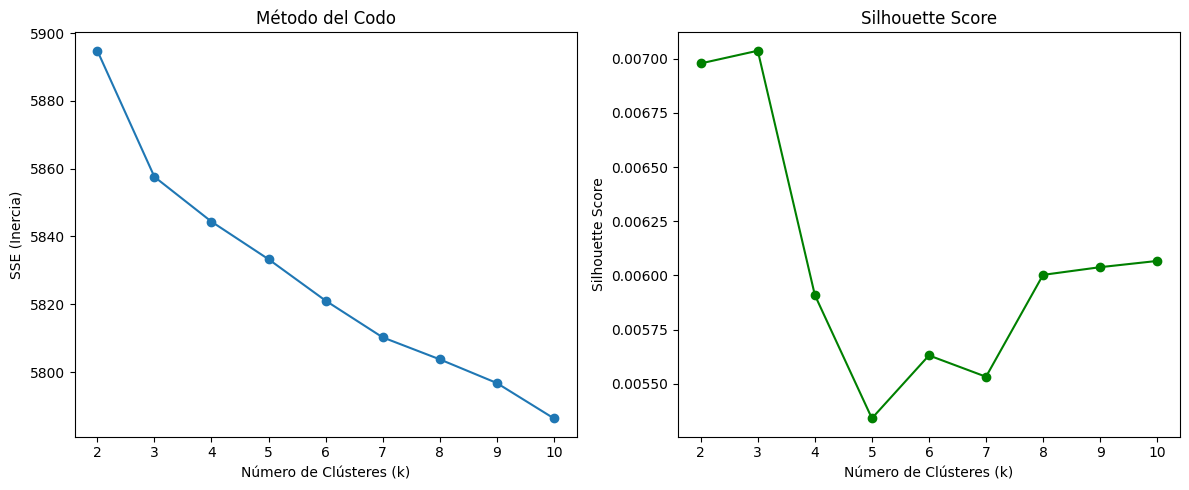

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

sse = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=13)
    km.fit(X_tfidf)
    sse.append(km.inertia_)
    silhouette_scores.append(silhouette_score(X_tfidf, km.labels_))

# Gráfica del codo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K, sse, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('SSE (Inercia)')

# Gráfica de Silhouette
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker='o', color='green')
plt.title('Silhouette Score')
plt.xlabel('Número de Clústeres (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()


A**nálisis del Método del Codo (SSE)**

La curva no tiene un “codo” claro y marcado, lo que sugiere que los grupos no están perfectamente definidos en el espacio vectorial.

Sin embargo, hay un pequeño cambio de pendiente alrededor de k=3, lo cual podría ser una opción razonable si buscamos simplicidad interpretativa.



---

**Análisis del Silhouette Score**

El pico máximo del Silhouette Score está en k=3, con un valor ligeramente superior a otros valores de k.

Aunque los valores de Silhouette Score son bajos (lo cual es común en texto TF-IDF con muchos documentos cortos y dispersos), aún así nos sirve para comparar entre valores.


**Conclusión: Elegir k = 3**

Justificación:

* Es el punto más alto en el gráfico de Silhouette.

* Representa el punto de cambio de curvatura más evidente (aunque sutil) en el método del codo.

* Un número pequeño de clústeres puede facilitar la interpretación (como adjetivos positivos, negativos, neutros; o estilos formales vs informales).

**Aplicamos K-means con K = 3**

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=13)
labels = kmeans.fit_predict(X_tfidf)

# Añadimos los clústeres al DataFrame
df['Cluster'] = labels


**Visualización con PCA (reducción a 2D)**

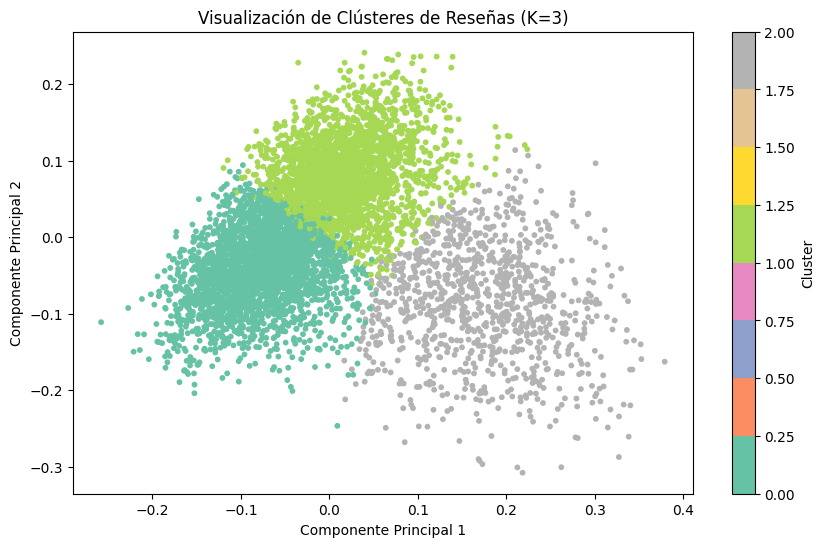

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set2', s=10)
plt.title('Visualización de Clústeres de Reseñas (K=3)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()


**Palabras más representativas de cada cluster**

In [ ]:
import numpy as np

# Obtener centroides y vocabulario
centroids = kmeans.cluster_centers_
terms = vectorizer.get_feature_names_out()

# Mostrar las 10 palabras más relevantes por clúster
top_n = 10
for i, centroid in enumerate(centroids):
    top_indices = centroid.argsort()[-top_n:][::-1]
    top_words = [terms[ind] for ind in top_indices]
    print(f"\n Palabras más representativas del Clúster {i}:")
    print(", ".join(top_words))



 Palabras más representativas del Clúster 0:
hotel, room, great, stay, location, good, not, staff, nice, clean

 Palabras más representativas del Clúster 1:
not, room, hotel, stay, no, night, bed, bad, service, staff

 Palabras más representativas del Clúster 2:
resort, not, beach, food, pool, good, great, time, day, room


**Interpretación de los Clusteres**

| **Clúster** | **Palabras Representativas**                            | **Temática Dominante**        | **Tipo de Palabras**                       | **Tonalidad**         |
| ----------- | ------------------------------------------------------- | ----------------------------- | ------------------------------------------ | --------------------- |
| **0**       | hotel, room, great, stay, location, good, staff, clean  | Opiniones generales positivas | Adjetivos positivos, comodidades           |  Positiva           |
| **1**       | not, room, no, bad, night, bed, service, staff          | Quejas y malas experiencias   | Negaciones, adjetivos negativos            |  Negativa           |
| **2**       | resort, beach, pool, food, good, great, time, day, room | Experiencias vacacionales     | Sustantivos temáticos, mezcla de opiniones |  Mixta (vacacional) |


 ver si estos clústeres tienen alguna relación con las calificaciones reales (Rating)

In [ ]:
pd.crosstab(df['Cluster'], df['Rating'], normalize='index') * 100


Rating,1,2,3,4,5
Cluster,,,,,
0,1.762590,6.654676,22.122302,33.237410,36.223022
1,40.070922,31.639086,17.494090,6.382979,4.412924
2,18.611670,22.837022,20.221328,20.321932,18.008048


Esto nos da una tabla donde cada fila es un clúster y muestra el porcentaje de reseñas por cada rating dentro de ese clúster.

Así podemos ver, por ejemplo, si el Clúster 0 tiene muchas de 5 estrellas, o si el Clúster 1 tiene muchas de 1 o 2 estrellas.



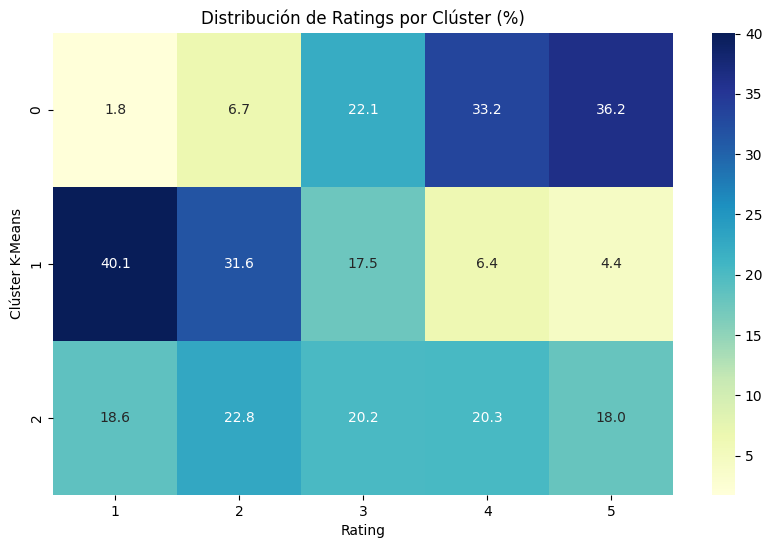

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ct = pd.crosstab(df['Cluster'], df['Rating'], normalize='index') * 100
plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title('Distribución de Ratings por Clúster (%)')
plt.ylabel('Clúster K-Means')
plt.xlabel('Rating')
plt.show()


El Clúster 0 reúne principalmente reseñas positivas, con más del 69% de calificaciones entre 4 y 5 estrellas. Refleja experiencias favorables, destacando palabras como “great” y “clean”.

El Clúster 1 agrupa comentarios negativos, con cerca del 72% de ratings bajos (1 o 2 estrellas). Las reseñas expresan quejas, usando términos como “bad” y “no”.

El Clúster 2 muestra opiniones mixtas, sin una tendencia clara. Las calificaciones están repartidas y combinan aspectos buenos y malos.



## 7. Regresión ordinal supervisada (predicción de rating)

In [ ]:
!pip install mord


  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=5f2482c5b03ad8ea689a2ec1ff9b91ae6a8f6ca7424855c3b46b863d58e42cc8
  Stored in directory: /root/.cache/pip/wheels/d1/fc/57/f2a2ad4ed0491ab6d5bb8642a90f1da9469397641e914743da
Successfully built mord


In [ ]:
from sklearn.model_selection import train_test_split
from mord import LogisticIT
from sklearn.metrics import mean_absolute_error

# Definir etiquetas y características
X = X_tfidf
y = df['Rating']

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo de regresión ordinal
model = LogisticIT()
model.fit(X_train, y_train)

# Predecir ratings
preds = model.predict(X_test)

# Calcular error absoluto medio
mae = mean_absolute_error(y_test, preds)
print("Mean Absolute Error:", round(mae, 3))


Mean Absolute Error: 0.553


El modelo de regresión ordinal logró predecir las calificaciones con un error medio de aproximadamente 0.55 estrellas. Esto indica un buen desempeño, considerando que las etiquetas van de 1 a 5 y el modelo solo se entrena con texto. Las predicciones se aproximan bastante a los valores reales, lo cual valida la utilidad del modelo para tareas de análisis de sentimiento y predicción de rating.

**Predicciones vs Valores Reales**

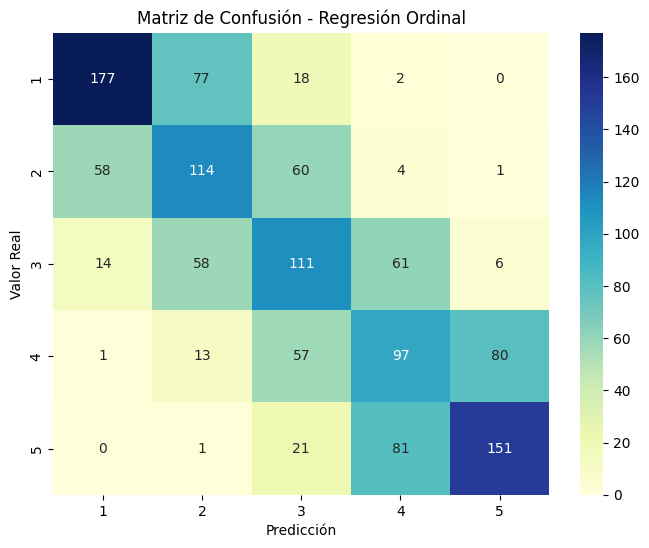

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Crear matriz de confusión
cm = confusion_matrix(y_test, preds, labels=[1, 2, 3, 4, 5])

# Mostrar como heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=[1,2,3,4,5], yticklabels=[1,2,3,4,5])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Regresión Ordinal')
plt.show()


El modelo acierta con bastante frecuencia, sobre todo en las clases más extremas:

* Para rating 1, se predijo correctamente en 177 casos, aunque 77 fueron clasificados como 2, lo cual es un error leve. El modelo rara vez se equivoca por más de un punto aquí.

* Para rating 5, se acertaron 151 casos, y la mayoría de los errores fueron por un solo nivel (predicho como 4).

* Rating 3 muestra más dispersión: aunque se predijo correctamente 111 veces, también fue confundido como 2 (60 casos) y 4 (61 casos), lo que sugiere que el modelo tiene más dificultad para clasificar las reseñas neutras o intermedias.

Por lo tanto, podemos concluir que predice con buena precisión los extremos (1 y 5 estrellas), mientras que tiene más errores en los niveles intermedios (2 a 4), especialmente para las reseñas con calificación 3. Aun así, la mayoría de los errores ocurren por solo 1 punto de diferencia, lo cual es aceptable y consistente con el bajo MAE (0.55).

### 7.1 Evaluación

In [ ]:
from scipy.stats import spearmanr

# Porcentaje de predicciones dentro de ±1 estrella del valor real
accuracy_within_1 = sum(abs(preds - y_test) <= 1) / len(y_test)

# Correlación de Spearman (ordinal)
spearman_corr, _ = spearmanr(preds, y_test)

print("Accuracy ±1 estrella:", round(accuracy_within_1, 3))
print("Spearman correlation:", round(spearman_corr, 3))


Accuracy ±1 estrella: 0.936
Spearman correlation: 0.826


El modelo predijo la calificación correcta o con solo 1 estrella de diferencia en el 93.6 % de los casos, lo cual es un rendimiento muy alto y práctico para aplicaciones reales. Además, la correlación de Spearman de 0.826 indica que el modelo respeta bastante bien el orden de las calificaciones (por ejemplo, predice más alto para reseñas más positivas).

Podemos concluir que el modelo de regresión ordinal alcanzó un 93.6 % de aciertos dentro de un margen de ±1 estrella y mostró una alta correlación con los valores reales (ρ = 0.826), lo que demuestra que logra capturar adecuadamente el orden de las opiniones en las reseñas.

### 7.1 Generacion y distribucion de los coeficientes

- Obtener los coeficientes
- Asociar con las palabras del vocabulario
- Graficar las n palabras mas y menos relevantes

Obtener los coeficientes y asociarlos al vocabulario


In [ ]:
coefs = model.coef_

features = vectorizer.get_feature_names_out()

coef_df = pd.DataFrame({'palabra': features, 'coeficiente': coefs})
coef_df = coef_df.sort_values('coeficiente', ascending=False)


Graficar palabras más y menos relevantes

<ipython-input-41-2876628735>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coeficiente', y='palabra', data=coef_df.head(top_n), palette='Greens_r')
<ipython-input-41-2876628735>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coeficiente', y='palabra', data=coef_df.tail(top_n), palette='Reds')


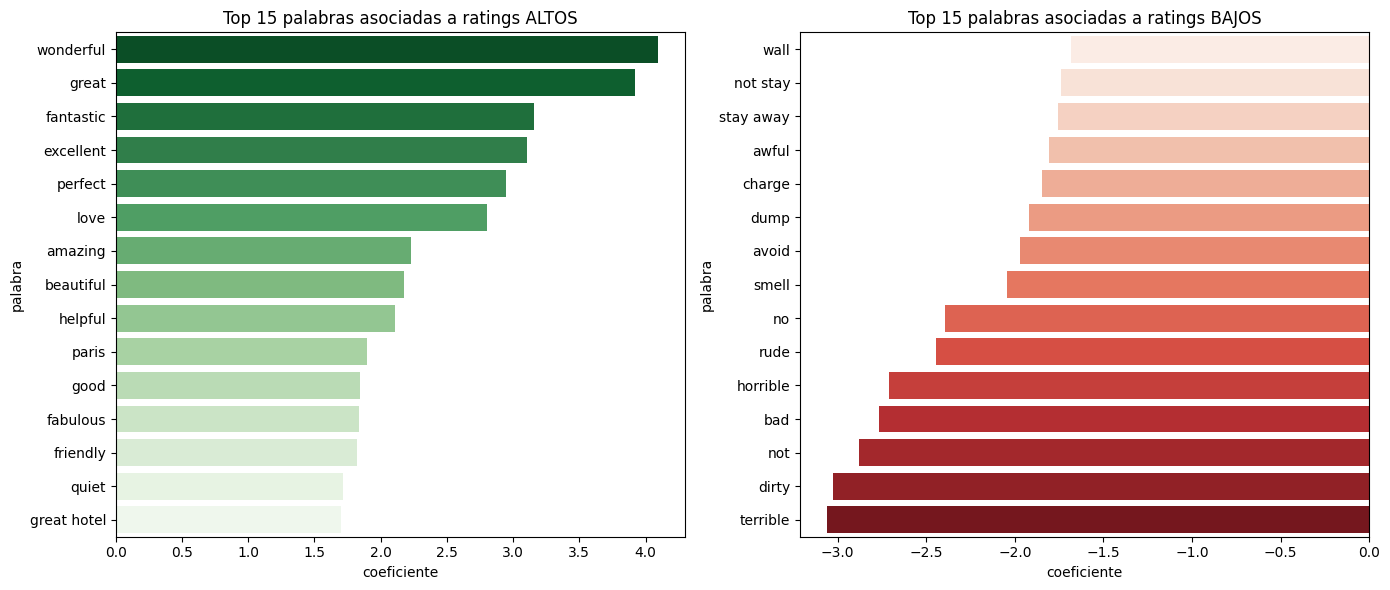

In [ ]:
top_n = 15

plt.figure(figsize=(14, 6))

# Positivas (asocian con ratings altos)
plt.subplot(1, 2, 1)
sns.barplot(x='coeficiente', y='palabra', data=coef_df.head(top_n), palette='Greens_r')
plt.title(f'Top {top_n} palabras asociadas a ratings ALTOS')

# Negativas (asocian con ratings bajos)
plt.subplot(1, 2, 2)
sns.barplot(x='coeficiente', y='palabra', data=coef_df.tail(top_n), palette='Reds')
plt.title(f'Top {top_n} palabras asociadas a ratings BAJOS')

plt.tight_layout()
plt.show()


Al analizar los coeficientes, notamos que las palabras con mayor influencia positiva en la predicción de ratings altos son términos como "wonderful", "great", "fantastic" y "excellent".

Estas palabras suelen estar asociadas a experiencias muy positivas y a usuarios satisfechos con su estancia.

Por otro lado, las palabras que más empujan las predicciones hacia ratings bajos incluyen "terrible", "dirty", "not", "bad" y "horrible". Estas expresiones reflejan descontento y problemas durante la experiencia del usuario, como falta de limpieza o mal servicio.

Esto también nos confirma que el modelo está capturando correctamente el tono emocional de las reseñas, y utiliza palabras clave relevantes para estimar de forma coherente las calificaciones.

## 8 Reflexión


- ¿Qué representa cada coeficiente en el modelo de regresión ordinal?



---



Cada coeficiente indica qué tanto influye una palabra en aumentar o disminuir la calificación predicha. Un valor positivo empuja la predicción hacia ratings más altos, mientras que uno negativo la orienta hacia ratings bajos.



---


- ¿Qué impacto tendría usar todo el texto (no solo palabras relevantes) como entrada al modelo? ¿Qué ganarías o perderías?


---

Usar todo el texto podría aportar más contexto, pero también introduciría ruido. Ganaría algo de información temática o de estilo, pero perdería claridad emocional, lo que puede dificultar que el modelo identifique qué parte del texto realmente influye en la calificación.


---



- ¿Por qué usamos solo palabras con carga emocional (relevantes para VADER) como entrada al modelo?


---


Porque son las que más relación tienen con el tono de la reseña y, por lo tanto, con la calificación. Estas palabras cargadas de emoción ayudan al modelo a enfocarse en lo que realmente diferencia una experiencia positiva de una negativa.


---


- ¿Podrías usar los clústeres de palabras (de K-means) como nuevas características para el modelo? ¿Cómo?




---

Sí. Podría contar cuántas palabras de cada clúster aparecen en una reseña y usar esas frecuencias como nuevas columnas. Eso permitiría al modelo aprovechar patrones temáticos o emocionales agrupados automáticamente.



---




- ¿En qué otros contextos podrías usar este enfoque de "filtrado emocional" previo al modelado?



---

En análisis de encuestas de satisfacción, reseñas de productos, atención al cliente o incluso análisis de redes sociales, donde el tono emocional suele ser más relevante que el contenido literal.



---




- ¿Qué ventaja tiene usar regresión ordinal frente a una clasificación tradicional multiclase?



---

La regresión ordinal respeta el orden natural de las categorías (por ejemplo, que 4 estrellas está más cerca de 5 que de 1), lo que mejora la interpretación del modelo y penaliza menos los errores leves.

